In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities import get_git_repo_path, log_bin

# Setup
git_path = get_git_repo_path()
n_parts = ["40", "61", "95", "148", "230", "356", "551", "854", "1322", "2048"]

target_frequency = 150929  # MHz
ref_time = 463.7943 # LJ time in fs
ref_temp = 50.3219 # LJ temp in K

In [12]:
# Output containers
R1_at_target = []
R2_at_target = []
std_R1_at_target = []
std_R2_at_target = []
Gij_in_zero = []
std_Gij_in_zero = []
correlation_functions = []

# Read data
for npart in n_parts:

    R1_at_target_T = []
    R2_at_target_T = []
    Gij_in_zero_T = []

    R1_spectra = []
    R2_spectra = []
    Gij_T = []

    for n in np.arange(1, 11):

        result_file = f"n{npart}/result{n}.npy"
        
        if not os.path.exists(result_file):
            print(f"Warning: Missing result file for n={npart}")
            continue

        data = np.load(result_file, allow_pickle=True).item()
        
        time_vector = np.real(data["t"])
        freq_vector = np.real(data["f"])
        idx_closest = np.argmin(np.abs(freq_vector - target_frequency))

        correlation_functions.append(data["C"])

        _, R1_spectra_log = log_bin(freq_vector[1:], data["R1"][1:], num_bins = 200)
        freq_vector_log, R2_spectra_log = log_bin(freq_vector[1:], data["R2"][1:], num_bins = 200)
        time_vector_log, correlation_function_log = log_bin(time_vector[1:], correlation_functions[-1][1:], num_bins = 200)

        np.savetxt(f"n{npart}/R1_vs_f_n{n}.dat", np.vstack([freq_vector_log, R1_spectra_log]).T)
        np.savetxt(f"n{npart}/R2_vs_f_n{n}.dat", np.vstack([freq_vector_log, R2_spectra_log]).T)
        np.savetxt(f"n{npart}/Gij_vs_t_n{n}.dat", np.vstack([time_vector_log, correlation_function_log]).T)

        R1_spectra.append(R1_spectra_log)
        R2_spectra.append(R2_spectra_log)
        R1_at_target_T.append(data["R1"][idx_closest])
        R2_at_target_T.append(data["R2"][idx_closest])
        Gij_in_zero_T.append(data["C"][0])
        Gij_T.append(correlation_function_log)

    R1_at_target.append(np.mean(R1_at_target_T))
    R2_at_target.append(np.mean(R2_at_target_T))
    std_R1_at_target.append(np.std(R1_at_target_T)/np.sqrt(len(R1_at_target_T)))
    std_R2_at_target.append(np.std(R2_at_target_T)/np.sqrt(len(R2_at_target_T)))

    R1_spectra_log = np.mean(R1_spectra, axis=0)
    R2_spectra_log = np.mean(R2_spectra, axis=0)
    Gij_spectra_log = np.mean(Gij_T, axis=0)
    Gij_in_zero.append(np.mean(Gij_in_zero_T))

    std_Gij_in_zero.append(np.std(Gij_in_zero_T)/np.sqrt(len(Gij_in_zero_T)))

    np.savetxt(f"n{npart}/R1_vs_f.dat", np.vstack([freq_vector_log, R1_spectra_log]).T)
    np.savetxt(f"n{npart}/R2_vs_f.dat", np.vstack([freq_vector_log, R2_spectra_log]).T)
    np.savetxt(f"n{npart}/Gi_vs_f.dat", np.vstack([time_vector_log, Gij_spectra_log]).T)

R1_at_target = np.array(R1_at_target)
R2_at_target = np.array(R2_at_target)
std_R1_at_target = np.array(std_R1_at_target)
std_R2_at_target = np.array(std_R2_at_target)
Gij_in_zero = np.array(Gij_in_zero)

np.savetxt("R1_at_target_vs_n.dat", np.vstack([np.int32(n_parts), R1_at_target, std_R1_at_target]).T)
np.savetxt("R2_at_target_vs_n.dat", np.vstack([np.int32(n_parts), R2_at_target, std_R2_at_target]).T)
np.savetxt("Gij_in_zero_vs_n.dat", np.vstack([np.int32(n_parts), Gij_in_zero, std_Gij_in_zero]).T)

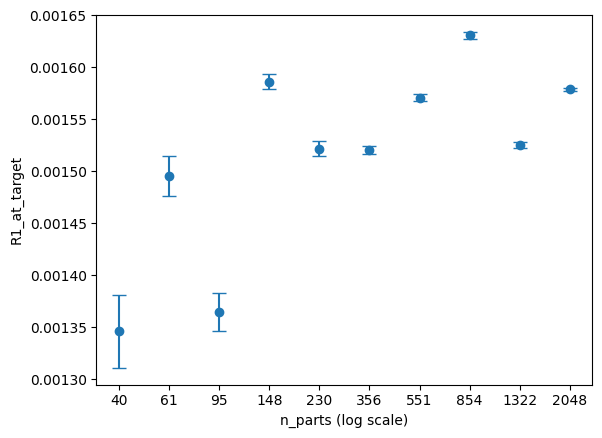

In [13]:
plt.errorbar(n_parts, R1_at_target, yerr=std_R1_at_target, fmt='o', capsize=5, label='Error Bars')
plt.xlabel('n_parts (log scale)')
plt.ylabel('R1_at_target')
plt.show()

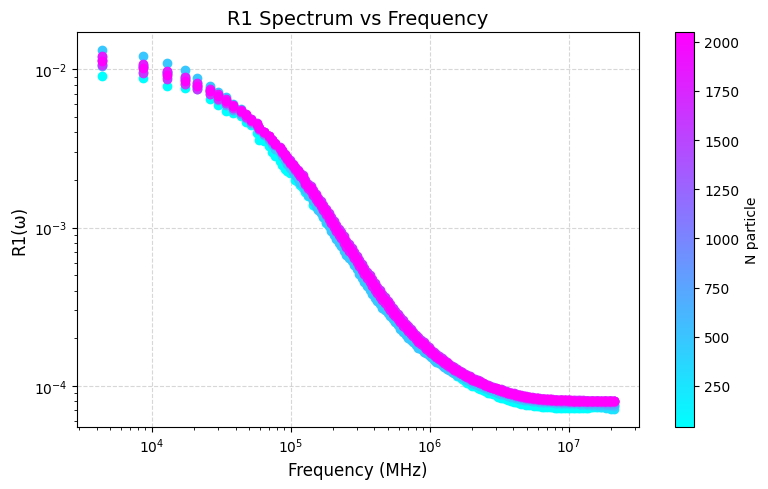

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (n, color) in enumerate(zip(n_parts, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"n{n}/R1_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"N = {np.int32(n):.1f}", color=color)

# Axis labels and title
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("R1(ω)", fontsize=12)
ax.set_title("R1 Spectrum vs Frequency", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=n_parts[0], vmax=n_parts[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="N particle")

plt.tight_layout()
plt.savefig("R1_spectrum.png", dpi=300)
plt.show()

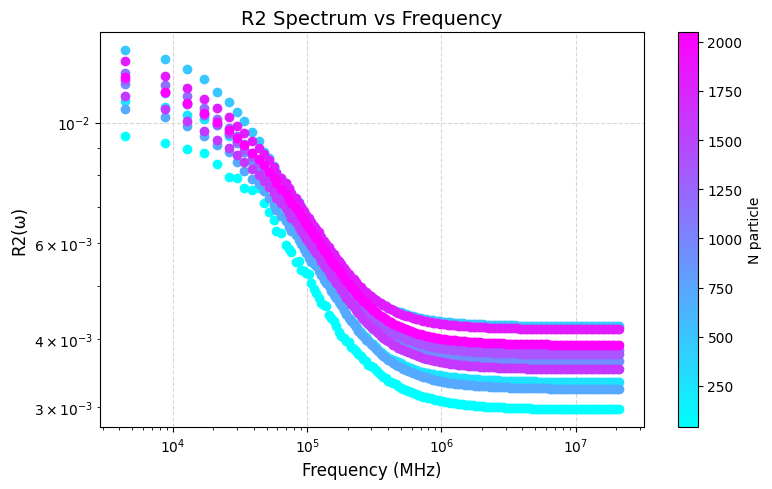

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (n, color) in enumerate(zip(n_parts, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"n{n}/R2_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"N = {np.int32(n):.1f}", color=color)

# Axis labels and title
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("R2(ω)", fontsize=12)
ax.set_title("R2 Spectrum vs Frequency", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=n_parts[0], vmax=n_parts[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="N particle")

plt.tight_layout()
plt.savefig("R2_spectrum.png", dpi=300)
plt.show()



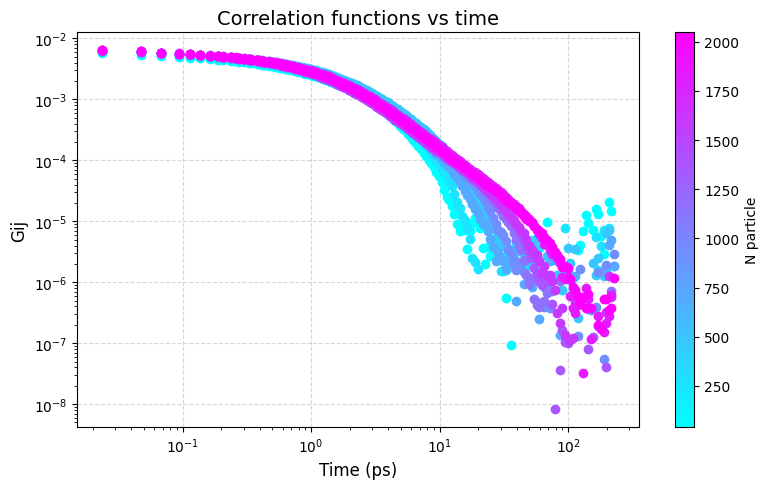

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

# Colormap and color assignment
cmap = plt.cm.cool
colors = cmap(np.linspace(0, 1, len(R1_spectra)))

# Plot each R1 spectrum
for i, (n, color) in enumerate(zip(n_parts, colors)):
    freq_vector_log, R1_spectra_log = np.loadtxt(f"n{n}/Gi_vs_f.dat").T
    ax.loglog(freq_vector_log, R1_spectra_log, "o", label=f"N = {np.int32(n):.1f}", color=color)

# Axis labels and title
ax.set_xlabel("Time (ps)", fontsize=12)
ax.set_ylabel("Gij", fontsize=12)
ax.set_title("Correlation functions vs time", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.5)

# Colorbar representing temperature gradient
norm = plt.Normalize(vmin=n_parts[0], vmax=n_parts[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label="N particle")

plt.tight_layout()
plt.savefig("correlation_functions.png", dpi=300)
plt.show()
